In [1]:
import pandas as pd
import io
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

# download nltk sources
nltk.download('punkt')
nltk.download('stopwords')
# transfer csv to df
file_path = 'C:/Users/70794/news/internet_us_clean.csv' 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\70794\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\70794\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import pandas as pd
import io
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
import string
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# read csv as df
df = pd.read_csv(file_path, delimiter=',')


In [4]:
df

,id,title,body,day,year,month
0,1.0,Bitter Debate on Privacy Divides Two Experts,Questions about the data-collection practice...,30.0,1999.0,12.0
1,2.0,BUSINESS DIGEST,"Nasdaq Ends Above 4,000 And Is Up 84% For th...",30.0,1999.0,12.0
2,3.0,Charities Cash In by Playing the Name Game,Interested in granting the wish of a child w...,30.0,1999.0,12.0
3,4.0,INCOMING;\nShopping Adventures Online,"To the Editor: ""Click and Heat, Thawing Opti...",30.0,1999.0,12.0
4,5.0,"Linking Classrooms, a World Apart, via the Int...",ANYONE who walked by Lawrence H. Landweber's...,30.0,1999.0,12.0
...,...,...,...,...,...,...
7000,6998.0,May 15-21: Mixed Signals;\nThe Information Fut...,Is the smart money backing away from the inf...,22.0,1994.0,5.0
7001,6999.0,Old-Liner Mead Going Off-Line - Correction App...,If the Mead Corporation decided to print the...,22.0,1994.0,5.0
7002,7000.0,COMPANY NEWS;\nDow Jones and West to Link Data...,In yet another effort to make information se...,18.0,1994.0,5.0
7003,7001.0,Mead to Sell Its Data Base Unit,At a time when communications and entertainm...,17.0,1994.0,5.0


### 用spacy对body列进行词形还原，lemmalize。

In [5]:
import spacy

# load spacy
nlp = spacy.load('en_core_web_sm')

# define to lemmatize the text
def lemmatize_text(text):
    if isinstance(text, str):  # 确保输入是字符串
        doc = nlp(text)
        return " ".join([token.lemma_ for token in doc])
    else:
        return ""  

# save as lemma column
df['lemma'] = df['body'].apply(lemmatize_text)

print(df['lemma'])


0          question about the data - collection practi...
1          Nasdaq end above 4,000 and be up 84 % for t...
2          interested in grant the wish of a child wit...
3          to the Editor : " Click and Heat , Thawing ...
4          ANYONE who walk by Lawrence H. Landweber 's...
                              ...                        
7000       be the smart money back away from the infor...
7001       if the Mead Corporation decide to print the...
7002       in yet another effort to make information s...
7003       at a time when communication and entertainm...
7004       Mead Data Central and Disclosure Inc. yeste...
Name: lemma, Length: 7005, dtype: object


### 把lemma分割成了tokens。stopwords使用了自带的停用词库和自己添加的停用词。
### 自定义停用词的计算方法我在Methodology里写的是TF-IDF的方法。wiki：https://zh.wikipedia.org/wiki/Tf-idf
### 实际上是提取了高频词然后把看起来无意义的词语摘了出来。

In [11]:

# transfer n/a, transfer context to string
df['lemma'] = df['lemma'].fillna('').astype(str)

# Define custom stopwords
custom_stopwords = set([
    'say', 'would', 'one', 'use', 'make', 'like', 'also', 'go', 'get', 'take', 'could', 'newyork times'
])

# Combine NLTK stopwords with custom stopwords
combined_stopwords = set(stopwords.words('english')).union(custom_stopwords)


# prepare for cleaning
def clean_and_tokenize(text):
    # change to lowercase
    text = text.lower()
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # seperate words
    tokens = word_tokenize(text)
    # remove stopwords
    stop_words = combined_stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# add tokens to new column
df['tokens'] = df['lemma'].apply(clean_and_tokenize)

# print results
print(df[['lemma', 'tokens']].head())

                                               lemma  \
0     question about the data - collection practi...   
1     Nasdaq end above 4,000 and be up 84 % for t...   
2     interested in grant the wish of a child wit...   
3     to the Editor : " Click and Heat , Thawing ...   
4     ANYONE who walk by Lawrence H. Landweber 's...   

                                              tokens  
0  [question, data, collection, practice, subsidi...  
1  [nasdaq, end, 4000, 84, year, nasdaq, composit...  
2  [interested, grant, wish, child, serious, illn...  
3  [editor, click, heat, thawing, optional, dec, ...  
4  [anyone, walk, lawrence, h, landweber, compute...  


In [12]:
df.to_csv('C:/Users/70794/news/internet_us_tokens.csv', index=False)

In [4]:
file_path = 'C:/Users/70794/news/internet_us_tokens.csv'
df = pd.read_csv(file_path, delimiter=',')


### 就是下面这样计算的：

In [58]:
# Get stopwords
stop_words = set(stopwords.words('english'))

# Initialize a Counter to count word frequencies
word_counts = Counter()

# Iterate through each row, tokenize, and remove stopwords
for text in df['lemma']:
    if isinstance(text, str):  # Ensure the text is of string type
        # Tokenize
        words = word_tokenize(text.lower())  # Convert text to lowercase
        # Filter out stopwords
        filtered_words = [word for word in words if word.isalpha() and word not in stop_words]
        # Update word frequency counts
        word_counts.update(filtered_words)

# Get the top ten most common words and their counts
most_common_words = word_counts.most_common(50)

# Output results
for word, count in most_common_words:
    print(f'{word}: {count}')


say: 41736
internet: 32552
company: 27176
web: 17373
site: 17239
line: 14608
computer: 14486
service: 14288
year: 13554
would: 12393
new: 12374
one: 12280
use: 11575
make: 10611
like: 10178
microsoft: 9806
million: 9800
information: 9106
people: 9032
business: 9000
software: 8047
also: 8038
time: 7848
stock: 7673
go: 7369
percent: 7331
online: 7318
network: 7123
technology: 7022
market: 6985
last: 6979
get: 6917
offer: 6860
world: 6753
system: 6609
many: 6312
user: 6299
include: 6297
call: 6241
first: 6218
america: 6217
two: 5988
customer: 5935
newyork: 5876
e: 5761
take: 5757
share: 5689
day: 5537
could: 5516
mail: 5483


### 词云，实际上没有用到

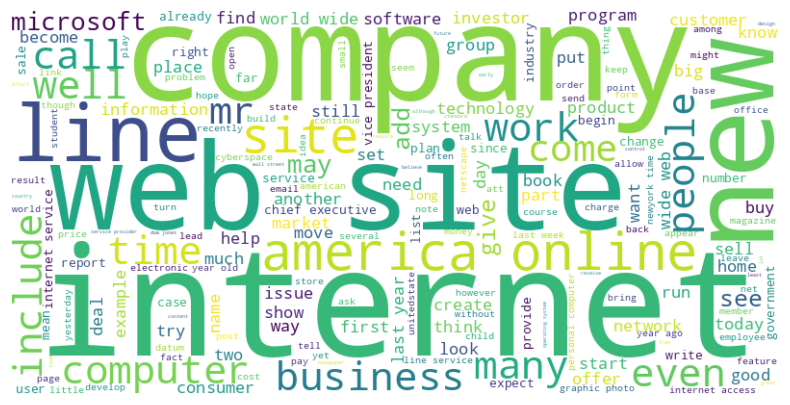

In [42]:

from wordcloud import WordCloud

# load csv and generate word cloud
def generate_wordcloud_from_tokens(file_path, tokens_column, custom_stopwords=None):
    # load csv
    df = pd.read_csv(file_path)
    
    # read tokens column
    text = ' '.join(df[tokens_column].dropna().astype(str))
    
    # remove punctuations
    text = text.replace("'", "").replace("[", "").replace("]", "")
    
    # customize stopwords
    if custom_stopwords is None:
        custom_stopwords = set()
    else:
        custom_stopwords = set(custom_stopwords)  
    
    # generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', 
                          max_words=200, stopwords=custom_stopwords).generate(text)
    
    # show word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off') 
    plt.show()

# main
def main():
    input_file = 'C:/Users/70794/news/internet_us_tokens.csv'  
    tokens_column = 'tokens'  
    
    custom_stopwords = ['say', 'would', 'one', 'use', 'make', 'like', 'also', 'go', 'get', 'take', 'could', 'newyork times'] 
    
    generate_wordcloud_from_tokens(input_file, tokens_column, custom_stopwords)

if __name__ == '__main__':
    main()


In [5]:
df

,id,title,body,day,year,month,lemma,tokens
0,1.0,Bitter Debate on Privacy Divides Two Experts,Questions about the data-collection practice...,30.0,1999,12,question about the data - collection practi...,"['question', 'data', 'collection', 'practice',..."
1,2.0,BUSINESS DIGEST,"Nasdaq Ends Above 4,000 And Is Up 84% For th...",30.0,1999,12,"Nasdaq end above 4,000 and be up 84 % for t...","['nasdaq', 'end', '4000', '84', 'year', 'nasda..."
2,3.0,Charities Cash In by Playing the Name Game,Interested in granting the wish of a child w...,30.0,1999,12,interested in grant the wish of a child wit...,"['interested', 'grant', 'wish', 'child', 'seri..."
3,4.0,INCOMING;\nShopping Adventures Online,"To the Editor: ""Click and Heat, Thawing Opti...",30.0,1999,12,"to the Editor : "" Click and Heat , Thawing ...","['editor', 'click', 'heat', 'thawing', 'option..."
4,5.0,"Linking Classrooms, a World Apart, via the Int...",ANYONE who walked by Lawrence H. Landweber's...,30.0,1999,12,ANYONE who walk by Lawrence H. Landweber 's...,"['anyone', 'walk', 'lawrence', 'h', 'landweber..."
...,...,...,...,...,...,...,...,...
7001,6998.0,May 15-21: Mixed Signals;\nThe Information Fut...,Is the smart money backing away from the inf...,22.0,1994,5,be the smart money back away from the infor...,"['smart', 'money', 'back', 'away', 'informatio..."
7002,6999.0,Old-Liner Mead Going Off-Line - Correction App...,If the Mead Corporation decided to print the...,22.0,1994,5,if the Mead Corporation decide to print the...,"['mead', 'corporation', 'decide', 'print', 'co..."
7003,7000.0,COMPANY NEWS;\nDow Jones and West to Link Data...,In yet another effort to make information se...,18.0,1994,5,in yet another effort to make information s...,"['yet', 'another', 'effort', 'information', 's..."
7004,7001.0,Mead to Sell Its Data Base Unit,At a time when communications and entertainm...,17.0,1994,5,at a time when communication and entertainm...,"['time', 'communication', 'entertainment', 'gi..."


### 下面是为了主题建模

In [7]:
import tomotopy as tp
import little_mallet_wrapper
import seaborn
import glob
from pathlib import Path
import re
# Download NLTK stopwords if not already present
nltk.download('stopwords')

# Define custom stopwords
custom_stopwords = set([
    'say', 'would', 'one', 'use', 'make', 'like', 'also', 'go', 'get', 'take', 'could', 'newyork times'
])

# Combine NLTK stopwords with custom stopwords
combined_stopwords = set(stopwords.words('english')).union(custom_stopwords)

# Convert combined stopwords to a list (if required by little_mallet_wrapper)
combined_stopwords_list = list(combined_stopwords)

# Create lists for the data.
training_data = []
original_texts = []
titles = []

# Define a function to clean data
def preprocess_text(tokens, title):
    # Join list of tokens into a single string
    if isinstance(tokens, list):
        text = ' '.join(tokens)
    else:
        text = str(tokens)
    
    # Remove everything unnecessary
    processed_text = little_mallet_wrapper.process_string(
        text, 
        numbers='remove', 
        lowercase=True, 
        remove_stop_words=True, 
        remove_punctuation=True,
        stop_words=combined_stopwords_list  # Use the combined stopwords list
    )
    
    # Add the cleaned data into the lists
    training_data.append(processed_text)
    original_texts.append(text)
    titles.append(title)
df.apply(lambda x: preprocess_text(x['tokens'], x['id']), axis=1)

# To ensure the custom stopwords are being applied correctly
print("Custom stopwords have been added successfully.")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\70794\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Custom stopwords have been added successfully.


In [8]:
# Applying the preprocess function to the data frame, we take the content for cleaning and title for identification
df.apply(lambda x: preprocess_text(x['tokens'], 
                                            x['id']), 
                  axis=1)

0       None
1       None
2       None
3       None
4       None
        ... 
7001    None
7002    None
7003    None
7004    None
7005    None
Length: 7006, dtype: object

In [9]:

# Number of topics to return
num_topics = 10
# Numer of topic words to print out
num_topic_words = 10

# Intialize the model
model = tp.LDAModel(k=num_topics)

# Add each document to the model, after splitting it up into words
for text in training_data:
    model.add_doc(text.strip().split())

print("Topic Model Training...\n\n")
# Iterate over the data 10 times
iterations = 10
for i in range(0, 100, iterations):
    model.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')


Topic Model Training...


Iteration: 0	Log-likelihood: -9.36029930181176
Iteration: 10	Log-likelihood: -8.86411327576936
Iteration: 20	Log-likelihood: -8.749477969561127
Iteration: 30	Log-likelihood: -8.684119933275324
Iteration: 40	Log-likelihood: -8.641052483769322
Iteration: 50	Log-likelihood: -8.613326356039645
Iteration: 60	Log-likelihood: -8.593913551206958
Iteration: 70	Log-likelihood: -8.580888418073975
Iteration: 80	Log-likelihood: -8.570341196243128
Iteration: 90	Log-likelihood: -8.559509153415961


In [71]:

# range of topics range(4:19)
# return the amount of topics trained and the average coherence for the model

def model_adjusting(training_data, amount):
    coherences =[]
    for num in amount:
        
        # Intialize the model with the topics
        model = tp.LDAModel(k=num)
        
        # Add each document to the model, after splitting it up into words
        for tweet in training_data:
            model.add_doc(tweet.strip().split())
            
        # Train the model   
        iterations = 10
        for i in range(0, 100, iterations):
            model.train(iterations)
            
        # Get coherence
        coh = tp.coherence.Coherence(model, coherence='c_v')
        average_coherence = coh.get_score()
        coherences.append(average_coherence)

        # Print coherence resuls
        print('\n==== Coherence : {} ===='.format('c_v'))
        print('Average:', average_coherence, '\nAmount of Topics:', num)
        
    # Plot results
    
    plt.plot(amount, coherences)


==== Coherence : c_v ====
Average: 0.5372742580994962 
Amount of Topics: 5

==== Coherence : c_v ====
Average: 0.5450658187270164 
Amount of Topics: 6

==== Coherence : c_v ====
Average: 0.553488356087889 
Amount of Topics: 7

==== Coherence : c_v ====
Average: 0.5296746580861509 
Amount of Topics: 8

==== Coherence : c_v ====
Average: 0.5411012709140777 
Amount of Topics: 9

==== Coherence : c_v ====
Average: 0.5548781346529722 
Amount of Topics: 10

==== Coherence : c_v ====
Average: 0.5531459786675194 
Amount of Topics: 11

==== Coherence : c_v ====
Average: 0.558781427393357 
Amount of Topics: 12

==== Coherence : c_v ====
Average: 0.5658819848528274 
Amount of Topics: 13

==== Coherence : c_v ====
Average: 0.5619337441399693 
Amount of Topics: 14

==== Coherence : c_v ====
Average: 0.5722281525035698 
Amount of Topics: 15

==== Coherence : c_v ====
Average: 0.5818541351996828 
Amount of Topics: 16

==== Coherence : c_v ====
Average: 0.5905856851269218 
Amount of Topics: 17

==== 

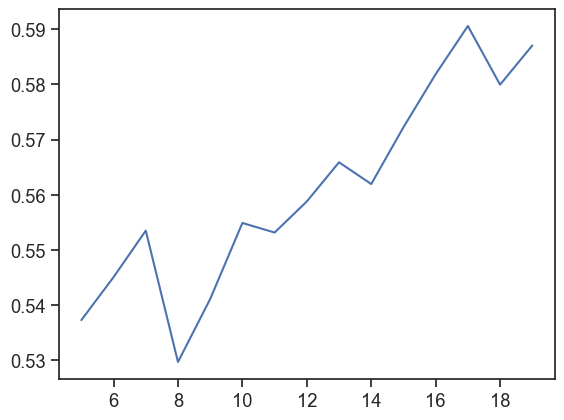

In [72]:
model_adjusting(training_data, range(5,20))

In [73]:
# There are different metrics for coherence, we choose `c_v`

coh = tp.coherence.Coherence(model, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model.k)]

print('==== Coherence : {} ===='.format('c_v'))
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
print()

==== Coherence : c_v ====
Average: 0.5666210990399122 
Per Topic: [0.5764228671789169, 0.5372944124042988, 0.6008426994085312, 0.3790123835206032, 0.7375986486673355, 0.5600695967674255, 0.5060522526502609, 0.7240273535251618, 0.5178710430860519, 0.5270197331905365]



### 下面是计算每篇文章最接近哪个主题，也就是我们最终分析的对象。让每个文章只对应一个主题

In [11]:

from nltk.stem import WordNetLemmatizer

# Download NLTK resources if not already present
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Define custom stopwords
custom_stopwords = set(['say', 'would', 'one', 'use', 'make', 'like', 'also', 'go', 'get', 'take', 'could'])

# Combine NLTK stopwords with custom stopwords
combined_stopwords = set(stopwords.words('english')).union(custom_stopwords)

# Create lists for the data
training_data = []
original_texts = []
titles = []

# Define a function to clean and preprocess text
def preprocess_text(tokens, title):
    # Join list of tokens into a single string
    if isinstance(tokens, list):
        text = ' '.join(tokens)
    else:
        text = str(tokens)

    # Remove everything unnecessary using little_mallet_wrapper
    processed_text = little_mallet_wrapper.process_string(
        text,
        numbers='remove',
        lowercase=True,
        remove_stop_words=True,
        remove_punctuation=True,
        stop_words=list(combined_stopwords)  # Use the combined stopwords list
    )
    
    # Lemmatize the processed text
    lemmatized_tokens = ' '.join([lemmatizer.lemmatize(word) for word in processed_text.split()])

    # Add the cleaned data into the lists
    training_data.append(lemmatized_tokens)
    original_texts.append(text)
    titles.append(title)

# Assuming df is your DataFrame with 'tokens' and 'id' columns
df.apply(lambda x: preprocess_text(x['tokens'], x['id']), axis=1)

print("Custom stopwords have been added successfully.")

# Now we can proceed to training the model
# Initialize your topic model
model = tp.LDAModel(k=10)  # Adjust the number of topics as needed

# Add processed documents to the model
for text in training_data:
    if text:  # Ensure text is not empty
        model.add_doc(text.split())  # Ensure each text is split into tokens
    else:
        print("Skipping empty document.")

# Train the model
model.train(1000)  # Number of iterations can be adjusted


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\70794\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\70794\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Custom stopwords have been added successfully.
Skipping empty document.
Skipping empty document.
Skipping empty document.
Skipping empty document.
Skipping empty document.
Skipping empty document.
Skipping empty document.
Skipping empty document.
Skipping empty document.
Skipping empty document.
Skipping empty document.
Skipping empty document.
Skipping empty document.
Most relevant topics have been saved successfully.


In [49]:

# Create a list to store the most relevant topic for each document
most_relevant_topics = []

# Get topic distributions for each document and find the most relevant topic
for text in training_data:
    if text:  # Ensure text is not empty
        try:
            topic_dist, _ = model.infer(model.make_doc(text.split()))
            most_relevant_topic = topic_dist.argmax()  # Get the index of the most relevant topic
            most_relevant_topics.append(most_relevant_topic)
        except Exception as e:
            print(f"Error processing text: {text}")
            print(f"Error: {e}")
    else:
        most_relevant_topics.append(None)  # If empty, append None or some default value

# Create a DataFrame with ID and the most relevant topic
results_df = pd.DataFrame({
    'id': range(1, len(most_relevant_topics) + 1),  # ID from 1 to N
    'topic': most_relevant_topics  # Most relevant topic index for each document
})

# Save results to a CSV file
results_df.to_csv('document_most_relevant_topics_us.csv', index=False)

print("Most relevant topics have been saved successfully.")


Most relevant topics have been saved successfully.


### 打印主题

In [50]:

# Print out top 10 words for each topic
print("\nTopic Model Results:\n\n")

# Create lists to save the topics and words
topics = []
topic_individual_words = []

for topic_number in range(0, num_topics):
    topic_words = ' '.join(word for word, prob in model.get_topic_words(topic_id=topic_number, top_n=num_topic_words))
    topics.append(topic_words)
    topic_individual_words.append(topic_words.split())
    print(f"✨Topic {topic_number}✨\n\n{topic_words}\n")


Topic Model Results:


✨Topic 0✨

site web page search world include offer link information art

✨Topic 1✨

internet law government information federal privacy state court site group

✨Topic 2✨

service internet company online america network access line cable million

✨Topic 3✨

internet people line many even time year way see know

✨Topic 4✨

stock company share percent million market investor year price trading

✨Topic 5✨

school university student year time library newyork college state work

✨Topic 6✨

company web site medium advertising internet news million service line

✨Topic 7✨

microsoft software netscape company browser window internet system computer operating

✨Topic 8✨

customer site line company sell store sale service card business

✨Topic 9✨

computer software internet web system user technology information program company



### 给每个主题分类别。然后把每个文章的类别存到type列

In [5]:

# Load the existing results DataFrame (make sure the path is correct)
results_df = pd.read_csv('document_most_relevant_topics_us.csv')

# Define the mapping of topic indices to types
topic_type_mapping = {
    0: 'culture',
    1: 'policy',
    2: 'economy',
    3: 'community',
    4: 'economy',
    5: 'culture',
    6: 'economy',
    7: 'economy',
    8: 'economy',
    9: 'economy'
}

# Create a new column 'type' by mapping the 'topic' values
results_df['type'] = results_df['topic'].map(topic_type_mapping)

# Save the updated DataFrame to a new CSV file
results_df.to_csv('document_most_relevant_topics_with_type_us.csv', index=False)

print("Updated DataFrame with types has been saved successfully.")


Updated DataFrame with types has been saved successfully.


In [6]:

# Merge the DataFrames on 'id'
merged_df = pd.merge(df, results_df, how='left', left_on='id', right_on='id')

# Save the merged DataFrame to a new CSV file
merged_df.to_csv('internet_us_tokens_topic.csv', index=False)

In [7]:
file_path = 'internet_us_tokens_topic.csv'
df = pd.read_csv(file_path, delimiter=',')


In [8]:
df = merged_df

In [9]:
df

,id,title,body,day,year,month,lemma,tokens,topic,type
0,1.0,Bitter Debate on Privacy Divides Two Experts,Questions about the data-collection practice...,30.0,1999,12,question about the data - collection practi...,"['question', 'data', 'collection', 'practice',...",9.0,economy
1,2.0,BUSINESS DIGEST,"Nasdaq Ends Above 4,000 And Is Up 84% For th...",30.0,1999,12,"Nasdaq end above 4,000 and be up 84 % for t...","['nasdaq', 'end', '4000', '84', 'year', 'nasda...",4.0,economy
2,3.0,Charities Cash In by Playing the Name Game,Interested in granting the wish of a child w...,30.0,1999,12,interested in grant the wish of a child wit...,"['interested', 'grant', 'wish', 'child', 'seri...",5.0,culture
3,4.0,INCOMING;\nShopping Adventures Online,"To the Editor: ""Click and Heat, Thawing Opti...",30.0,1999,12,"to the Editor : "" Click and Heat , Thawing ...","['editor', 'click', 'heat', 'thawing', 'option...",8.0,economy
4,5.0,"Linking Classrooms, a World Apart, via the Int...",ANYONE who walked by Lawrence H. Landweber's...,30.0,1999,12,ANYONE who walk by Lawrence H. Landweber 's...,"['anyone', 'walk', 'lawrence', 'h', 'landweber...",3.0,community
...,...,...,...,...,...,...,...,...,...,...
7001,6998.0,May 15-21: Mixed Signals;\nThe Information Fut...,Is the smart money backing away from the inf...,22.0,1994,5,be the smart money back away from the infor...,"['smart', 'money', 'back', 'away', 'informatio...",9.0,economy
7002,6999.0,Old-Liner Mead Going Off-Line - Correction App...,If the Mead Corporation decided to print the...,22.0,1994,5,if the Mead Corporation decide to print the...,"['mead', 'corporation', 'decide', 'print', 'co...",3.0,community
7003,7000.0,COMPANY NEWS;\nDow Jones and West to Link Data...,In yet another effort to make information se...,18.0,1994,5,in yet another effort to make information s...,"['yet', 'another', 'effort', 'information', 's...",6.0,economy
7004,7001.0,Mead to Sell Its Data Base Unit,At a time when communications and entertainm...,17.0,1994,5,at a time when communication and entertainm...,"['time', 'communication', 'entertainment', 'gi...",6.0,economy


### 每个主题单独一个dataframe

In [33]:
filtered_data_8 = df[df['topic'] == 8]

In [34]:
filtered_data_0 = df[df['topic'] == 0]

In [35]:
filtered_data_1 = df[df['topic'] == 1]

In [36]:
filtered_data_2 = df[df['topic'] == 2]

In [37]:
filtered_data_3 = df[df['topic'] == 3]

In [38]:
filtered_data_4 = df[df['topic'] == 4]

In [39]:
filtered_data_5 = df[df['topic'] == 5]

In [40]:
filtered_data_6 = df[df['topic'] == 6]

In [41]:
filtered_data_7 = df[df['topic'] == 7]

In [42]:
filtered_data_9 = df[df['topic'] == 9]

### 计算了高频词，但没用

In [25]:

from nltk.probability import FreqDist
import string

# Ensure the NLTK stopwords are downloaded
nltk.download('stopwords')

# Get NLTK stopwords
nltk_stopwords = set(stopwords.words('english'))

# Define custom stopwords
custom_stopwords = ['say', 'would', 'one', 'use', 'make', 'like', 'also', 'go', 'get', 'take', 'could']  # You can add more custom stopwords

# Combine the stopword lists
combined_stopwords = nltk_stopwords.union(custom_stopwords)

# Define punctuation
punctuation = set(string.punctuation)

# Calculate the top 20 most frequent words for each DataFrame
for i in range(10):
    df_name = f'filtered_data_{i}'  # Dynamically generate DataFrame name
    df = eval(df_name)  # Use eval to get the corresponding DataFrame
    
    # Get the 'lemma' column, remove stopwords, punctuation, and convert to lowercase
    words = df['lemma'].dropna().astype(str).apply(lambda x: x.lower())  # Convert to lowercase
    filtered_words = [word for word in " ".join(words).split() 
                      if word not in combined_stopwords and word not in punctuation]
    
    # Use FreqDist to calculate word frequency
    freq_dist = FreqDist(filtered_words)
    
    # Get the top 20 most common words
    most_common_words = freq_dist.most_common(20)
    
    # Output results
    print(f"Top 20 most common words in {df_name}:")
    for word, frequency in most_common_words:
        print(f"{word}: {frequency}")
    print("\n")  # Separate the results of each DataFrame with a blank line


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\70794\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top 20 most common words in filtered_data_0:
's: 3257
site: 2390
internet: 2112
web: 1870
company: 1644
--: 1371
mr.: 1336
line: 1071
computer: 1008
new: 1003
year: 1001
service: 869
information: 778
people: 752
microsoft: 707
include: 701
page: 692
world: 647
offer: 645
time: 634


Top 20 most common words in filtered_data_1:
internet: 4239
's: 4190
company: 2898
mr.: 2642
site: 2125
web: 1959
computer: 1709
--: 1706
information: 1467
year: 1461
line: 1455
service: 1434
new: 1379
people: 1090
million: 907
law: 906
group: 904
network: 889
last: 876
business: 850


Top 20 most common words in filtered_data_2:
internet: 4610
's: 4415
company: 3735
service: 3714
online: 2070
line: 2054
america: 2040
mr.: 1750
--: 1564
new: 1517
computer: 1503
access: 1442
web: 1437
million: 1417
year: 1362
network: 1321
cable: 1273
at&t: 1184
offer: 1135
business: 1074


Top 20 most common words in filtered_data_3:
's: 5797
internet: 5090
company: 3690
mr.: 3434
--: 3368
site: 2853
web: 2782
computer: 261

C:\Users\70794\AppData\Local\Temp\ipykernel_22232\2589027588.py:36: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()  # Adjust layout


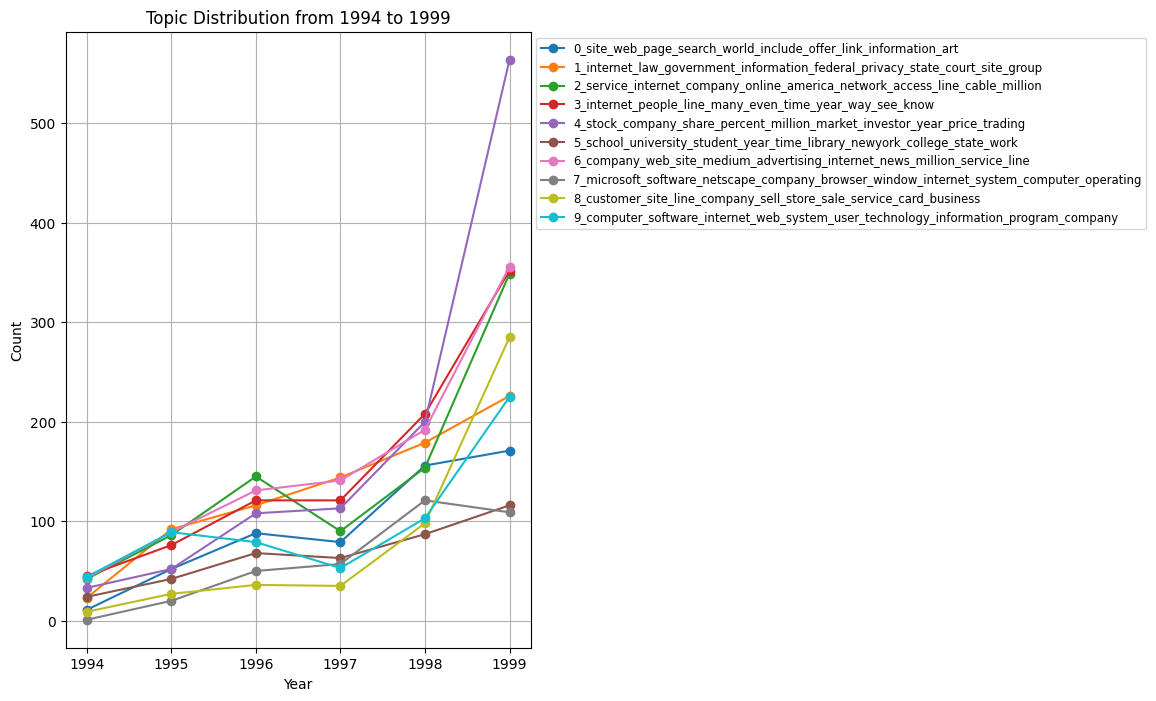

In [43]:

# Check and convert the year data type
df['year'] = pd.to_numeric(df['year'], errors='coerce')  # Convert to numeric
df = df.dropna(subset=['year'])  # Drop rows where the 'year' column is NaN

# Calculate the count of each topic for each year
topic_distribution = df.groupby(['year', 'topic']).size().unstack(fill_value=0)

# Define custom topic names and corresponding words
topic_names_with_words = {
    0: '0_site_web_page_search_world_include_offer_link_information_art',
    1: '1_internet_law_government_information_federal_privacy_state_court_site_group',
    2: '2_service_internet_company_online_america_network_access_line_cable_million',
    3: '3_internet_people_line_many_even_time_year_way_see_know',
    4: '4_stock_company_share_percent_million_market_investor_year_price_trading',
    5: '5_school_university_student_year_time_library_newyork_college_state_work',
    6: '6_company_web_site_medium_advertising_internet_news_million_service_line',
    7: '7_microsoft_software_netscape_company_browser_window_internet_system_computer_operating',
    8: '8_customer_site_line_company_sell_store_sale_service_card_business',
    9: '9_computer_software_internet_web_system_user_technology_information_program_company',
}

# Plot the line chart
plt.figure(figsize=(6, 8))  # Adjust the figure size to fit the text
for topic in topic_distribution.columns:
    plt.plot(topic_distribution.index, topic_distribution[topic], marker='o',
             label=topic_names_with_words.get(topic, f'Topic {topic}'))

plt.title('Topic Distribution from 1994 to 1999')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(topic_distribution.index)  # Ensure the years are ticks on the x-axis

# Adjust legend position
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')  # Place the legend on the right side
plt.grid()
plt.tight_layout()  # Adjust layout
plt.show()


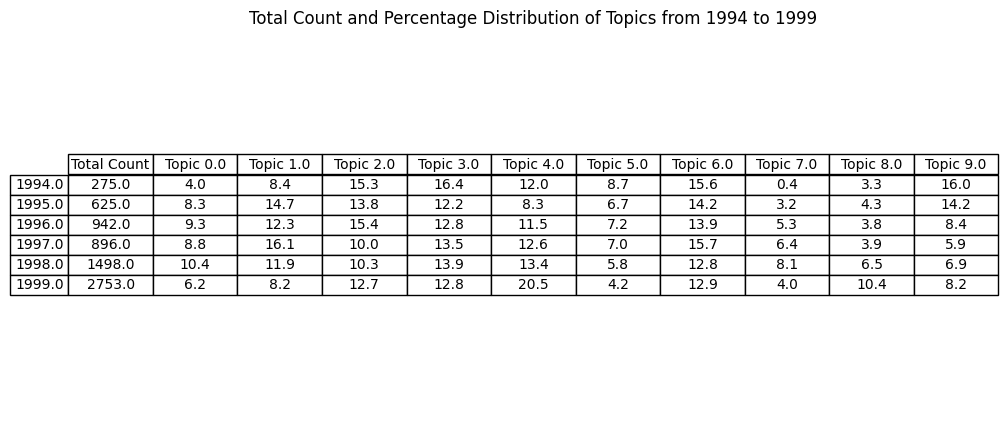

In [44]:
percentage_distribution = topic_distribution.div(topic_distribution.sum(axis=1), axis=0) * 100
total_count_per_year = topic_distribution.sum(axis=1)

# Plot total count and percentage table
fig, ax = plt.subplots(figsize=(10, 5))  # Create a new figure for the table
ax.axis('tight')
ax.axis('off')

# Create the total count and percentage table
combined_table_data = pd.DataFrame({
    'Total Count': total_count_per_year,
    **{f'Topic {topic}': percentage_distribution[topic].round(1) for topic in percentage_distribution.columns}
})

# Display in the table
table = ax.table(cellText=combined_table_data.values,
                 colLabels=combined_table_data.columns,
                 rowLabels=combined_table_data.index,
                 cellLoc='center', 
                 loc='center')
table.auto_set_font_size(False)  # Turn off automatic font size adjustment
table.set_fontsize(10)  # Set font size
table.scale(1.2, 1.2)  # Adjust table size

plt.title('Total Count and Percentage Distribution of Topics from 1994 to 1999')
plt.show()


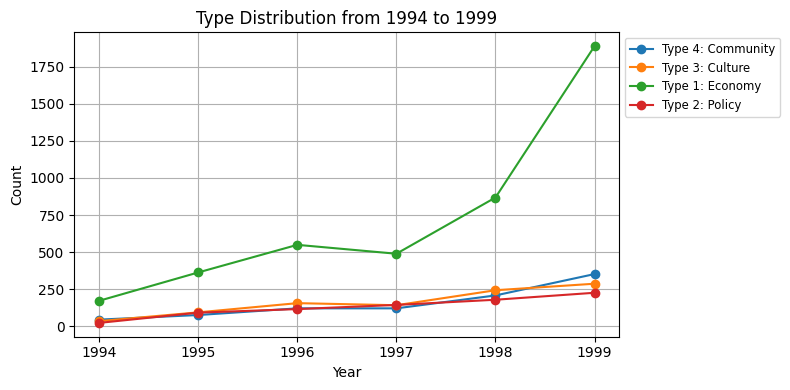

In [10]:
# Calculate the count of each topic for each year
topic_distribution = df.groupby(['year', 'type']).size().unstack(fill_value=0)

# Define custom line names and corresponding words
topic_names_with_words = {
    'economy': 'Type 1: Economy',
    'policy': 'Type 2: Policy',
    'culture': 'Type 3: Culture',
    'community' : 'Type 4: Community'
}

# Plot the line chart
plt.figure(figsize=(8, 4))  # Adjust the figure size to fit the text
for topic in topic_distribution.columns:
    plt.plot(topic_distribution.index, topic_distribution[topic], marker='o', label=topic_names_with_words.get(topic, f'Topic {topic}'))

plt.title('Type Distribution from 1994 to 1999')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(topic_distribution.index)  # Ensure the years are ticks on the x-axis

# Adjust legend position
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')  # Place the legend on the right side
plt.grid()
plt.tight_layout()  # Adjust layout
plt.show()


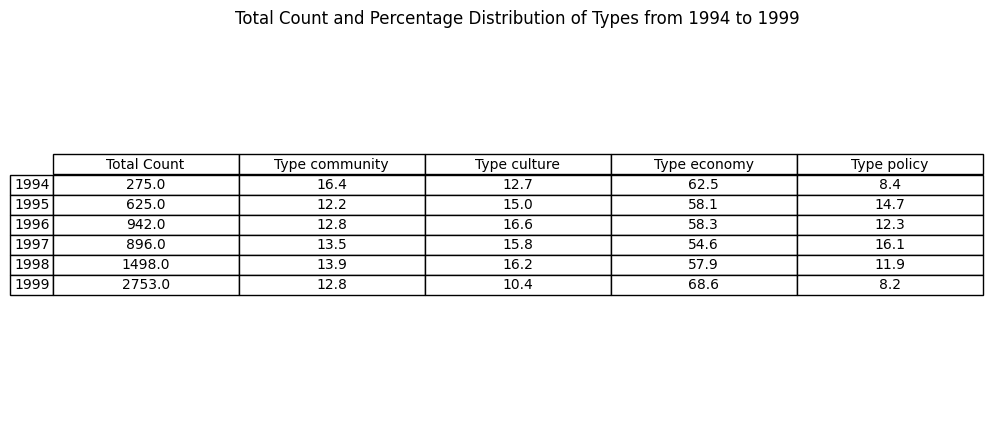

In [11]:
total_count_per_year = topic_distribution.sum(axis=1)

# Calculate the count of each type for each year
type_distribution = df.groupby(['year', 'type']).size().unstack(fill_value=0)

# Calculate the percentage of each type for each year
percentage_distribution = type_distribution.div(type_distribution.sum(axis=1), axis=0) * 100

# Plot total count and percentage table
fig, ax = plt.subplots(figsize=(10, 5))  # Create a new figure for the table
ax.axis('tight')
ax.axis('off')

# Create the total count and percentage table
combined_table_data = pd.DataFrame({
    'Total Count': total_count_per_year,
    **{f'Type {t}': percentage_distribution[t].round(1) for t in percentage_distribution.columns}
})

# Display in the table
table = ax.table(cellText=combined_table_data.values,
                 colLabels=combined_table_data.columns,
                 rowLabels=combined_table_data.index,
                 cellLoc='center', 
                 loc='center')
table.auto_set_font_size(False)  # Turn off automatic font size adjustment
table.set_fontsize(10)  # Set font size
table.scale(1.2, 1.2)  # Adjust table size

plt.title('Total Count and Percentage Distribution of Types from 1994 to 1999')
plt.show()


In [74]:
model.save('lda_model_us.bin') 


In [15]:
import pandas as pd
file_path = 'internet_us_tokens_topic.csv'
df_us = pd.read_csv(file_path, delimiter=',')


In [16]:
file_path = 'internet_cn_tokens_topic.csv'
df_cn = pd.read_csv(file_path, delimiter=',')


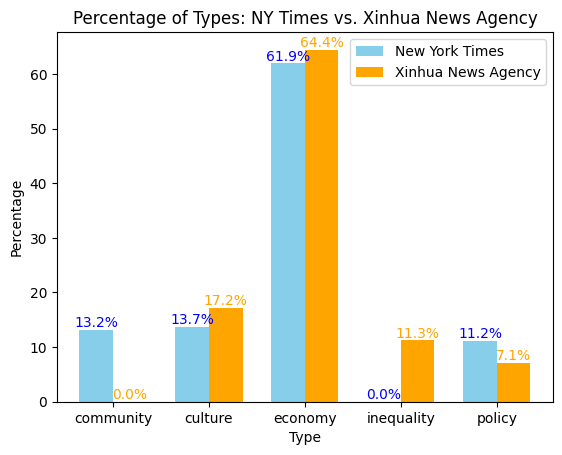

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Calculate percentages
us_counts_percent = df_us['type'].value_counts(normalize=True) * 100
cn_counts_percent = df_cn['type'].value_counts(normalize=True) * 100

# Combine the results into a DataFrame and handle any missing values
type_counts_percent = pd.DataFrame({'NY Times': us_counts_percent, 'XH News Agency': cn_counts_percent}).fillna(0)

# Labels and positions for the plot
labels = type_counts_percent.index  
x = np.arange(len(labels))  
width = 0.35  

# Define colors
ny_color = 'skyblue'
xh_color = 'orange'

# Plotting
fig, ax = plt.subplots()
ny_bars = ax.bar(x - width/2, type_counts_percent['NY Times'], width, label='New York Times', color=ny_color)
xh_bars = ax.bar(x + width/2, type_counts_percent['XH News Agency'], width, label='Xinhua News Agency', color=xh_color)

# Adding labels, title, and legend
ax.set_xlabel('Type')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Types: NY Times vs. Xinhua News Agency')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Adding percentage labels on top of each bar
for bar in ny_bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.1f}%', ha='center', color='blue')

for bar in xh_bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.1f}%', ha='center', color='orange')
plt.savefig("percentage_us_cn.jpg")

plt.show()


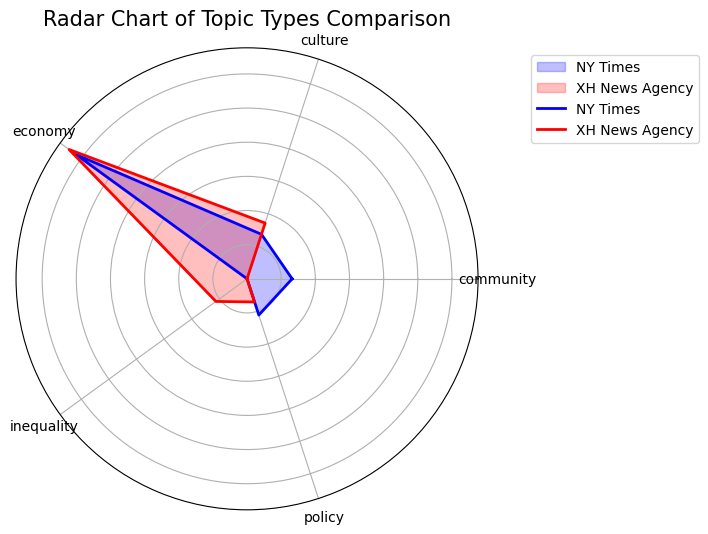

In [18]:

# 计算每个主题类型的占比
us_counts_percent = df_us['type'].value_counts(normalize=True) * 100
cn_counts_percent = df_cn['type'].value_counts(normalize=True) * 100

# 创建主题标签
labels = us_counts_percent.index.union(cn_counts_percent.index)

# 确保两个国家的占比长度一致
us_data = us_counts_percent.reindex(labels, fill_value=0).values
cn_data = cn_counts_percent.reindex(labels, fill_value=0).values

# 数据标准化为百分比
us_data = us_data / us_data.sum() * 100
cn_data = cn_data / cn_data.sum() * 100

# 雷达图绘制
num_vars = len(labels)

# 计算每个轴的角度
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# 完成雷达图的闭合
us_data = np.concatenate((us_data, [us_data[0]]))
cn_data = np.concatenate((cn_data, [cn_data[0]]))
angles += angles[:1]

# 创建图形
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# 绘制雷达图
ax.fill(angles, us_data, color='blue', alpha=0.25, label='NY Times')
ax.fill(angles, cn_data, color='red', alpha=0.25, label='XH News Agency')
ax.plot(angles, us_data, color='blue', linewidth=2, label='NY Times')
ax.plot(angles, cn_data, color='red', linewidth=2, label='XH News Agency')

# 设置标签
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

# 添加图例并移动到右侧
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1), fontsize='medium')

# 显示图形
plt.title('Radar Chart of Topic Types Comparison', size=15)
plt.savefig("radar_us_cn.jpg")

plt.show()

In [7]:
import tomotopy as tp
lda_model = tp.LDAModel.load("lda_model_us.bin")


# 以下没用

Average Coherence Score (UMass): -0.8656651378040264


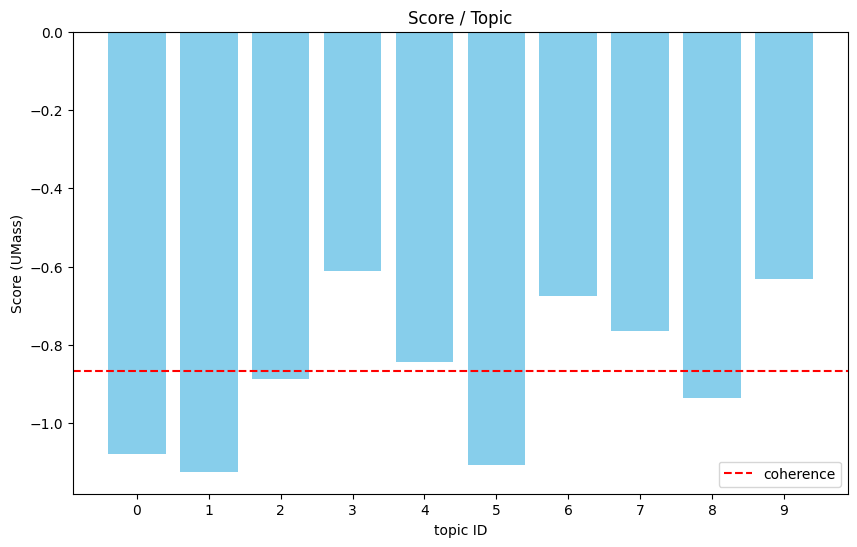

In [15]:
import tomotopy as tp
from tomotopy.coherence import Coherence
import matplotlib.pyplot as plt

# 假设你已经加载了一个 tomotopy 的模型 lda_model
# lda_model = tp.LDAModel.load("lda_model_us.bin")

# 计算每个主题的一致性分数
coherence_model = Coherence(lda_model, coherence='u_mass')

# 获取每个主题的前 n 个单词
top_n = 10  # 可以根据需要调整
topic_coherences = []
for topic_id in range(lda_model.k):
    # 获取主题中前 top_n 个单词
    words = [word for word, _ in lda_model.get_topic_words(topic_id, top_n=top_n)]
    # 计算一致性分数
    coherence_score = coherence_model.get_score(words)
    topic_coherences.append(coherence_score)

# 计算平均一致性分数
average_coherence = sum(topic_coherences) / len(topic_coherences)

print("Average Coherence Score (UMass):", average_coherence)

# 可视化一致性分数
plt.figure(figsize=(10, 6))
plt.bar(range(lda_model.k), topic_coherences, color='skyblue')
plt.xlabel('topic ID')
plt.ylabel('Score (UMass)')
plt.title('Score / Topic')
plt.xticks(range(lda_model.k))
plt.axhline(y=average_coherence, color='red', linestyle='--', label='coherence')
plt.legend()
plt.show()


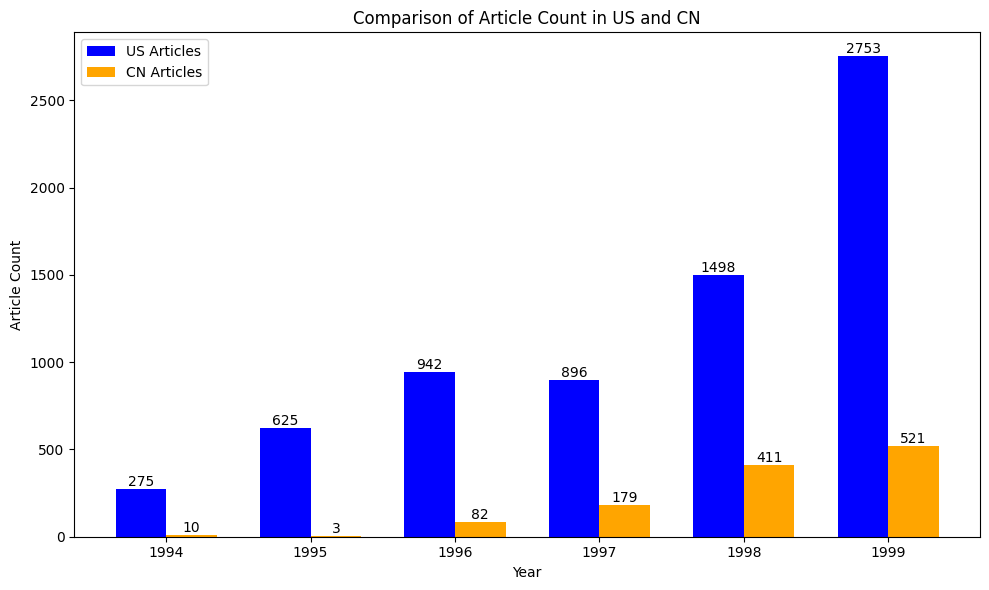

In [18]:
import matplotlib.pyplot as plt
import numpy as np
article_count_us = [275, 625, 942, 896, 1498, 2753]
article_count_cn = [10,3,82,179,411,521]

# x轴标签
categories = ['1994', '1995', '1996', '1997', '1998', '1999']

# x轴位置
x = np.arange(len(categories))

# 柱状图宽度
width = 0.35

# 创建柱状图
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, article_count_us, width, label='US Articles', color='blue')
bars2 = ax.bar(x + width/2, article_count_cn, width, label='CN Articles', color='orange')

# 添加标签和标题
ax.set_xlabel('Year')
ax.set_ylabel('Article Count')
ax.set_title('Comparison of Article Count in US and CN')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# 添加数据标签
def add_data_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

add_data_labels(bars1)
add_data_labels(bars2)

# 显示图表
plt.tight_layout()
plt.show()

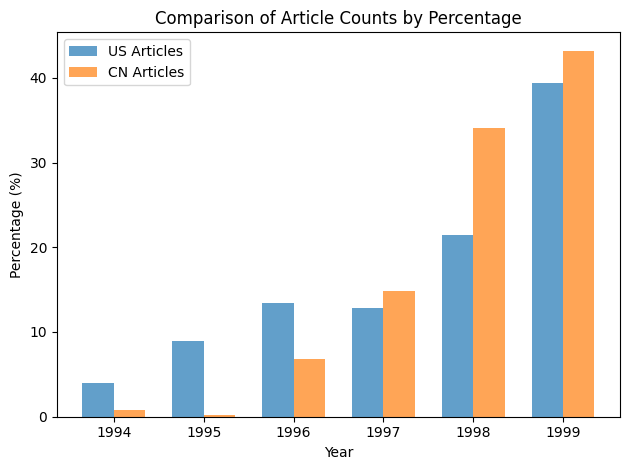

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# 数据
article_count_us = [275, 625, 942, 896, 1498, 2753]
article_count_cn = [10, 3, 82, 179, 411, 521]

# 计算总数
total_us = sum(article_count_us)
total_cn = sum(article_count_cn)

# 计算百分比
percentage_us = [count / total_us * 100 for count in article_count_us]
percentage_cn = [count / total_cn * 100 for count in article_count_cn]

# 设置柱状图位置
bar_width = 0.35
index = np.arange(len(percentage_us))

# 绘制柱状图
plt.bar(index, percentage_us, bar_width, label='US Articles', alpha=0.7)
plt.bar(index + bar_width, percentage_cn, bar_width, label='CN Articles', alpha=0.7)

# 添加标签和标题
plt.xlabel('Year')
plt.ylabel('Percentage (%)')
plt.title('Comparison of Article Counts by Percentage')
plt.xticks(index + bar_width / 2, ['1994', '1995', '1996', '1997', '1998', '1999'])
plt.legend()

# 显示图形
plt.tight_layout()
plt.show()


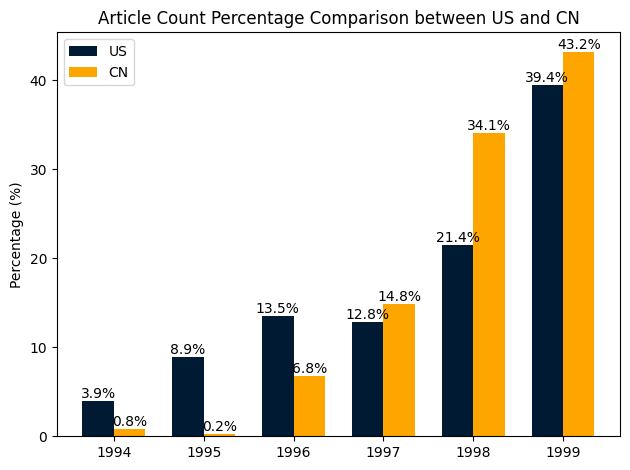

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Data
article_count_us = [275, 625, 942, 896, 1498, 2753]
article_count_cn = [10, 3, 82, 179, 411, 521]

# Calculate percentages
total_us = sum(article_count_us)
total_cn = sum(article_count_cn)

percentage_us = [count / total_us * 100 for count in article_count_us]
percentage_cn = [count / total_cn * 100 for count in article_count_cn]

# Bar chart settings
labels = ['1994', '1995', '1996', '1997', '1998', '1999']
x = np.arange(len(labels))
width = 0.35  # Width of the bars

# Create the bar chart
fig, ax = plt.subplots()

# Specify a single color for each group
bars_us = ax.bar(x - width/2, percentage_us, width, label='US', color='#001A33') 
bars_cn = ax.bar(x + width/2, percentage_cn, width, label='CN', color='orange') 

# Add percentage labels on top of the bars
for bar in bars_us:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}%', ha='center', va='bottom')

for bar in bars_cn:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}%', ha='center', va='bottom')

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('Percentage (%)')
ax.set_title('Article Count Percentage Comparison between US and CN')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [7]:
file_path = 'internet_us_tokens_topic.csv' 

In [8]:
# read csv as df
df = pd.read_csv(file_path, delimiter=',')


In [9]:
import pandas as pd

# 假设你的 DataFrame 叫做 df
# 首先筛选出符合条件的数据
filtered_df = df[df['topic'] == 3]

# 从筛选出的数据中随机抽取 20 条
sampled_df = filtered_df.sample(n=30)  # 可以设置 random_state 保持结果一致性


In [10]:
sampled_df

,id,title,body,day,year,month,lemma,tokens,topic,type
5673,5670.0,Disney to Buy Controlling Stake In Internet Pu...,"Expanding its recent embrace of cyberspace, ...",4.0,1997,4,"expand its recent embrace of cyberspace , t...","['expand', 'recent', 'embrace', 'cyberspace', ...",3.0,community
966,967.0,We Have Gone Too Far to Protect Internet Speech,"To the Editor: Re ""Some Enter the Fast Lane ...",2.0,1999,5,"to the editor : re "" some enter the Fast La...","['editor', 'enter', 'fast', 'lane', 'access', ...",3.0,community
2155,2156.0,"Obsessively Independent, Yahoo Is the Web's Sw...","For years, Timothy A. Koogle built high-perf...",23.0,1999,8,"for year , Timothy A. Koogle build high - p...","['year', 'timothy', 'koogle', 'build', 'high',...",3.0,community
5821,5818.0,Taking In the Sites;\nScout Getaway Options Or...,Hoping to escape the winter by getting away ...,6.0,1997,1,hope to escape the winter by get away to a ...,"['hope', 'escape', 'winter', 'away', 'dreamy',...",3.0,community
5585,5582.0,Sun Is Seeking Sales Abroad Of Latest Encrypti...,Sun Microsystems Inc. said today that it pla...,20.0,1997,5,Sun Microsystems Inc. say today that it pla...,"['sun', 'microsystems', 'inc', 'today', 'plan'...",3.0,community
326,327.0,"After 55 Years at Times, Rosenthal Is Packing Up","After 55 years as a reporter, foreign corres...",5.0,1999,11,"after 55 year as a reporter , foreign corre...","['55', 'year', 'reporter', 'foreign', 'corresp...",3.0,community
1233,1234.0,INTERNET'S IMAGE PROBLEM MAY DEPRESS USERS;\nO...,To the Editor: I'm surprised that no one has...,5.0,1998,9,to the Editor : I be surprised that no one ...,"['editor', 'surprised', 'suggest', 'obvious', ...",3.0,community
3280,3281.0,Your Average Traders,"To the Editor: Lori Aks Rosenberg (letter, M...",11.0,1999,5,to the Editor : Lori Aks Rosenberg ( letter...,"['editor', 'lori', 'aks', 'rosenberg', 'letter...",3.0,community
1223,1224.0,Writers' Consolation,To the Editor: I was pleased to see that Alb...,16.0,1998,9,to the Editor : I be pleased to see that Al...,"['editor', 'pleased', 'see', 'alberto', 'mangu...",3.0,community
6114,6111.0,"Capitol Hill Takes to Cyberspace, Though in Fi...",No lawmaker is more responsible for pushing ...,10.0,1996,7,no lawmaker be more responsible for push Co...,"['lawmaker', 'responsible', 'push', 'congress'...",3.0,community


In [11]:
# 逐行打印 title 列
for title in sampled_df['title']:
    print(title)

Disney to Buy Controlling Stake In Internet Publisher Starwave
We Have Gone Too Far to Protect Internet Speech
Obsessively Independent, Yahoo Is the Web's Switzerland;
Cutthroat Battles Are Ahead, Threatening a Stoic Resolve
Taking In the Sites;
Scout Getaway Options Or Feed Your Daydreams
Sun Is Seeking Sales Abroad Of Latest Encryption Software
After 55 Years at Times, Rosenthal Is Packing Up
INTERNET'S IMAGE PROBLEM MAY DEPRESS USERS;
On-Line Candor
Your Average Traders
Writers' Consolation
Capitol Hill Takes to Cyberspace, Though in Fits, Starts and Stumbles
PC Makers Cool to Microsoft's Push for WebTV
Compressed Data;
Backing for Bill To Shield Children
www.let's look@new jersey
SCREEN GRAB;
For All the Matador Types Out There
Live, Via Compuserve: It's On-Line With Al Gore
It's Make-or-Break Season at One Young Online Company
U.S. to Support Fewer Supercomputer Centers
CHATTER;
Still Coming From Outer Space
Stuck on the Web;
The Symptoms of Internet Addiction
A Parent's View of t